In [2]:
from distance.EuclideanDistance import EuclideanDistance
from utilities.visualization import Visualizer
from utilities.dataset_factory import DatasetFactory
from CL_utilities.top5_efficiency import top5eff
import numpy as np
import keras
from CL_utilities import loss_function
import tensorflow as tf

# Hyperparameters

In [3]:
image_size = (224, 224)
epochs = 10
batch_size = 16
margin = 0.5
training_pairs = 280
validation_pairs = 40
training_path = r"./data/FruitRecognition/Training"
validation_path = r"./data/FruitRecognition/Validation"

# Building training dataset 
# (1.) See Documentation to get info about structure of dataset

In [5]:
training_dataset = DatasetFactory.build_dataset(ds_path=training_path,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                max_iterations=training_pairs,
                                                method="contrastive_loss")
print(training_dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


(224, 224, 3)


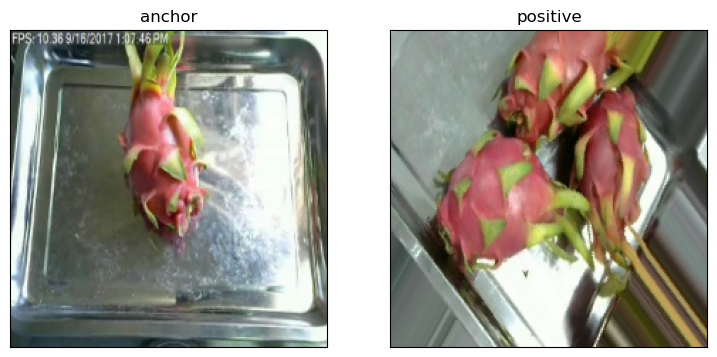

In [6]:
image, _ = next(iter(training_dataset))
anchor_img = np.asarray(image[0][0]).astype('float32')
positive_img = np.asarray(image[1][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img})
print(anchor_img.shape)

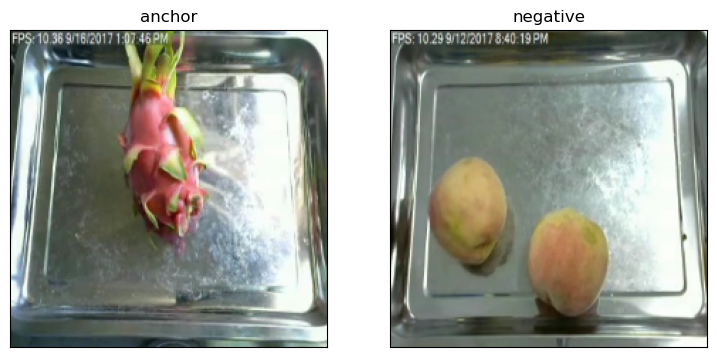

In [7]:
anchor_img = np.asarray(image[0][1]).astype('float32')
negative_img = np.asarray(image[1][1]).astype('float32')
Visualizer.visualize(**{"anchor": anchor_img, "negative" : negative_img})

# Creating validation dataset

In [8]:
validation_dataset = DatasetFactory.build_dataset(ds_path=training_path,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                max_iterations=training_pairs,
                                                method="contrastive_loss")
print(validation_dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


(224, 224, 3)


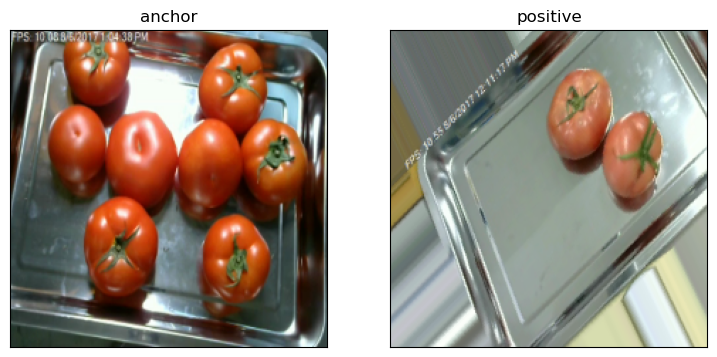

In [9]:
image, _ = next(iter(validation_dataset))
anchor_img = np.asarray(image[0][0]).astype('float32')
positive_img = np.asarray(image[1][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img})
print(anchor_img.shape)

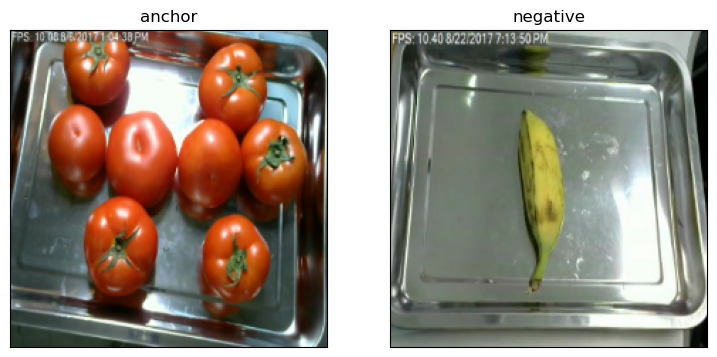

In [10]:
anchor_img = np.asarray(image[0][1]).astype('float32')
negative_img = np.asarray(image[1][1]).astype('float32')
Visualizer.visualize(**{"anchor": anchor_img, "negative" : negative_img})

In [11]:
# LOAD MODEL (TRANSFER LEARNING)

from tensorflow.keras.applications import VGG16
modelVGG = VGG16(weights='imagenet', include_top=False)

In [12]:
input_layer = keras.layers.Input((224,224,3))
x = modelVGG(input_layer)
# x = keras.layers.BatchNormalization()(input_layer)
# x = keras.layers.Conv2D(32, (5,5), activation="relu")(x)  
# x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
# x = keras.layers.Conv2D(64, (3,3), activation="relu")(x)
# x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
# x = keras.layers.Conv2D(128, (3,3), activation="relu")(x)
# x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(16, activation="relu")(x)
x = keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
embedding_network = keras.Model(input_layer, x)   # create instance of model called embedding_network


In [13]:
input_1 = keras.layers.Input(image_size + (3,))
input_2 = keras.layers.Input(image_size + (3,))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)
 
merge_layer_distance = keras.layers.Lambda(EuclideanDistance(), output_shape=(1,))([tower_1, tower_2])
siamese = keras.Model(inputs=[input_1, input_2], outputs=merge_layer_distance)

In [14]:
#Transfer MODEL: 
for layer in modelVGG.layers:
    layer.trainable = False

In [15]:
siamese.compile(loss=loss_function.loss(margin=margin), optimizer='adam', metrics=['accuracy'])
siamese.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 16)        │ 16,321,680 │ input_layer_2[0]… │
│ (Functional)        │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1)         │          0 │ functional_1[0][… │
│                     │                   │            │ functional_1[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,321,680 (62.26 MB)

 Trainable params: 1,606,864 (6.13 MB)

 Non-trainable params: 14,714,816 (56.13 MB)

# PARAMETERS of model

+ run:  siamese.fit if want to train new parameters
  + run: siamese.save_wages() if want to save trained parameters

+ run: siamese.load_wages() if want to load saved parameters (need to have same structure of model)

In [45]:
Trained_model_data = siamese.fit(training_dataset, 
                                 validation_data= validation_dataset, 
                                 batch_size = batch_size,
                                 epochs = epochs
                                )

Epoch 1/10
35/35 [==============================] - 188s 5s/step - loss: 0.4536 - accuracy: 0.5554 - val_loss: 0.1269 - val_accuracy: 0.6429
Epoch 2/10
35/35 [==============================] - 190s 6s/step - loss: 0.3565 - accuracy: 0.6304 - val_loss: 0.1704 - val_accuracy: 0.6768
Epoch 3/10
35/35 [==============================] - 195s 6s/step - loss: 0.2685 - accuracy: 0.6607 - val_loss: 0.1457 - val_accuracy: 0.7500
Epoch 4/10
35/35 [==============================] - 201s 6s/step - loss: 0.2251 - accuracy: 0.7143 - val_loss: 0.1586 - val_accuracy: 0.7411
Epoch 5/10
35/35 [==============================] - 192s 6s/step - loss: 0.1748 - accuracy: 0.7196 - val_loss: 0.1527 - val_accuracy: 0.7393
Epoch 6/10
35/35 [==============================] - 203s 6s/step - loss: 0.1444 - accuracy: 0.7714 - val_loss: 0.1105 - val_accuracy: 0.8125
Epoch 7/10
35/35 [==============================] - 181s 5s/step - loss: 0.1332 - accuracy: 0.7607 - val_loss: 0.0902 - val_accuracy: 0.8250
Epoch 8/10
35

# wages:

In [46]:
#Saving wages (Only after trained model)
siamese.save_weights('trained_models/VGG16_plus_dense_64_16.h5')


In [16]:
#Load wages (need to have same structure of model) 
siamese.load_weights('trained_models/VGG16_plus_dense_64_16.h5')

# Create representatives

In [17]:
# CREATE MEAN (of 5 IMAGES) REPRESENTATIVE VECTOR FOR EACH CLASS
import tensorflow as tf
from utilities.mapping import Mapper
import os
import random
import shutil

@staticmethod
class Representatives:
    def __init__(self, image_size):
        self.list_of_images = []
        self.list_of_labels = []
        self.List_mean_feature_vector_shop = np.zeros((23,16))
        self.image_size = image_size
    def create_representatives(self, number_of_representative):
        self.number_of_representative = number_of_representative
        
        shop_path = os.path.abspath("data/FruitRecognition/Shop_database")
        validation_path = r"./data/FruitRecognition/Validation/"
    
        for type_of_product in os.listdir(validation_path):
            val_dir = os.path.join(validation_path, type_of_product)
            shop_class_dir = os.path.join(shop_path, type_of_product)
    
            os.makedirs(shop_class_dir, exist_ok=True)
    
            for filename in os.listdir(shop_class_dir):
                file_path = os.path.join(shop_class_dir, filename)
                os.remove(file_path)
    
            files = [f for f in os.listdir(val_dir)]    #list of images

            for i in range(self.number_of_representative):
                random_selected_representative = random.choice(files)
                path_representative = os.path.join(val_dir,random_selected_representative)
                destination_path = os.path.join(shop_class_dir, random_selected_representative)
                shutil.copy(path_representative, destination_path)          
    def get_mean_representatives_for_each_class(self, fruit_names, fruit_paths, number_of_representative):
        self.fruits_names = fruit_names
        self.fruits_paths = fruit_paths
        self.number_repr = number_of_representative
        i=0
        j=0

        for i in range(len(fruits_paths)):
            for j in range(self.number_repr):
                path_to_image = Mapper(image_size)
                image = path_to_image._decode_and_resize(fruits_paths[i][j])
                self.list_of_images.append(image)
                self.list_of_labels.append(fruits_names[i])
            #print(list_of_labels)
        
            #___________________Get dimensions__________________________
            num_of_images = self.number_repr#len(list_of_images[0])  #one mean for each class
            size_feature_vector = embedding_network(tf.expand_dims(self.list_of_images[0], axis=0)).numpy()
            size_feature_vector = size_feature_vector.shape[1]   #get length
            #___________________________________________________________
            
            list_class_vectors = np.zeros((num_of_images, size_feature_vector))
                
            for num in range(self.number_repr):
                list_class_vectors[num] = embedding_network(tf.expand_dims(self.list_of_images[num], axis=0)).numpy()
            #print(list_class_vectors)    
                
            mean_feature_vector = np.mean(list_class_vectors, axis=0)   # mean vector for all representatives of class
            self.List_mean_feature_vector_shop[i] = mean_feature_vector
            print(fruits_names[i])
            print(self.List_mean_feature_vector_shop[i])
        
            self.list_of_images.clear()
            self.list_of_labels.clear()
            
        return self.List_mean_feature_vector_shop
    

In [21]:
# NEW SET OF REPRESENTATIVES  (changing images in file Dataset_shop)
num_of_imag_per_class = 20
Representatives(image_size).create_representatives(num_of_imag_per_class)

In [22]:
# Loading Representatives from dataset_shop

camera_path = 'data/FruitRecognition/Shop_database'
paths = DatasetFactory.give_paths_to_test(camera_path, 10)

fruits_names = []
fruits_paths = []
fruits_names = [key.split('/')[-1] for key in paths.keys()]
fruits_paths = [value for value in paths.values()]  # Get 5 representatives for each class
#print((fruits_paths[0][4]))


In [ ]:
# CREATE MEAN (of num_img IMAGES) REPRESENTATIVE VECTOR FOR EACH CLASS
num_img = 15
List_mean_feature_vector_shop = Representatives(image_size).get_mean_representatives_for_each_class(fruits_names, fruits_paths, num_img)


muskmelon
[0.04422092 0.02518079 0.44261106 0.25955044 0.40283238 0.2904436
 0.38452652 0.03276217 0.36600613 0.0303248  0.03039176 0.20372474
 0.04394805 0.15450194 0.31309142 0.        ]
Kiwi C
[0.         0.00836181 0.31675254 0.0024138  0.56238539 0.00261245
 0.27674621 0.         0.05192828 0.672054   0.         0.03208489
 0.17185345 0.0028759  0.07358641 0.00139827]
Apple A
[0.00000000e+00 0.00000000e+00 6.19012797e-01 1.47681580e-01
 4.56837513e-01 7.24937855e-02 2.11223822e-01 0.00000000e+00
 3.15779944e-01 5.77836050e-02 2.66797322e-02 1.59597402e-01
 2.65135850e-02 5.70393975e-04 4.33889757e-01 0.00000000e+00]
Apple C
[0.         0.00216338 0.64481206 0.04372456 0.3790415  0.04689075
 0.11627423 0.00764983 0.2010503  0.04993057 0.12932523 0.10206337
 0.03104931 0.00513608 0.57071176 0.        ]
Carambola
[0.26254029 0.42202883 0.11582063 0.05208432 0.06578522 0.50822625
 0.16707428 0.12444751 0.12838566 0.         0.31535705 0.08794499
 0.0104983  0.41277272 0.17722035 0.013

# Distances

In [104]:
def distance_between_vectors(vector1, vector2):
    vector1 = vector1 / tf.norm(vector1)   # length ov vector == 1
    vector2 = vector2 / tf.norm(vector2)
    sum_square = np.sum(np.square(vector1 - vector2))
    return tf.sqrt(tf.maximum(sum_square, keras.backend.epsilon()))

In [105]:
np.set_printoptions(precision=4)

distance1 = distance_between_vectors(List_mean_feature_vector_shop[0], List_mean_feature_vector_shop[16])
distance2 = distance_between_vectors(List_mean_feature_vector_shop[7], List_mean_feature_vector_shop[20])

print(f"Distance between {fruits_names[0]} and {fruits_names[16]}  == {distance1}")
print(f"Distance between {fruits_names[7]} and {fruits_names[20]}  == {distance2}\n")



Distance between muskmelon and Tomatoes  == 0.49703254030398875
Distance between guava B and Plum  == 0.3758597355374817


# Create test images

In [106]:
import random
def create_test_images():
    camera_images_list = []
    camera_labels_list = []
    path_test_eff = 'data/FruitRecognition/Test'
    data = DatasetFactory.give_paths_to_test(path_test_eff, 1)
    
    
    # Losowo wybieranie 10 zdjęć z każdego folderu
    camera_paths = [random.sample(paths_list, 10) for paths_list in data.values() if len(paths_list) >= 10]
    camera_paths = [path for sublist in camera_paths for path in sublist]  # Spłaszczanie listy list
    camera_names = [path.split('/')[-2] for path in camera_paths]  # Zakładam, że nazwa folderu jest właściwym labelem
    
    
    camera_feature_vector = np.zeros((len(camera_paths), 16))
    print(len(camera_paths))
    # Dekodowanie i przetwarzanie obrazów
    for i in range(len(camera_paths)):
        path_to_image1 = Mapper(image_size)
        img  = path_to_image1._decode_and_resize(camera_paths[i])
        camera_images_list.append(img)
        camera_labels_list.append(camera_names[i])  
        camera_feature_vector[i] = embedding_network(tf.expand_dims(camera_images_list[i],axis=0)).numpy()
        
    # Obliczanie odległości między wektorami cech
    distances = np.zeros(23)  # Zakładam, że istnieje 22 kategorie
    for i in range(23):
        distances[i] = distance_between_vectors(camera_feature_vector, List_mean_feature_vector_shop[i])
        
    return camera_feature_vector, distances, camera_paths, camera_names

In [107]:
camera_feature_vector, distances, camera_paths, camera_names = create_test_images()

230


# Find top5 efficiency of model and more info

In [119]:
efficiency = 0.
eff_one_example = 0.
for num_camera_images in range(len(camera_paths)):  #230 (10 images for each class)
    for i in range(23):
        distances[i] = distance_between_vectors(camera_feature_vector[num_camera_images], List_mean_feature_vector_shop[i])
    top5_dist, top5_lab = top5eff().find_top_5(distances, fruits_names)
    eff_one_example = top5eff().give_efficiency(camera_names[num_camera_images], top5_lab, top5_dist)
    efficiency += eff_one_example
    if(eff_one_example <= 0.92):
        print(top5_lab)
        print(camera_names[num_camera_images])
        print(camera_paths[num_camera_images])
efficiency = efficiency/len(camera_paths)*100
print(f"Efficiency of model in our metric: {efficiency}")

['Apple F', 'muskmelon', 'Pear', 'Orange', 'Apple D']
Apple A
data/FruitRecognition/Test/Apple A/Apple 686.png
['Mango', 'Orange', 'Apple F', 'muskmelon', 'Pomegranate']
Carambola
data/FruitRecognition/Test/Carambola/Carambola 001705.png
['Mango', 'Orange', 'Apple F', 'muskmelon', 'Tomatoes']
Carambola
data/FruitRecognition/Test/Carambola/Carambola 00706.png
['Orange', 'Apple F', 'muskmelon', 'Pear', 'Mango']
Mango
data/FruitRecognition/Test/Mango/Mango001420.png
['Pear', 'muskmelon', 'Apple F', 'Orange', 'guava A']
Mango
data/FruitRecognition/Test/Mango/Mango001231.png
['Apple C', 'Persimmon', 'Tomatoes', 'Plum', 'Apple A']
Apple B
data/FruitRecognition/Test/Apple B/461red applee09201461.png
['Apple D', 'Peach', 'Apple E', 'Apple A', 'guava B']
Pear
data/FruitRecognition/Test/Pear/Pear 1335.png
['Tomatoes', 'Apple A', 'Apple C', 'Apple F', 'Peach']
Pomegranate
data/FruitRecognition/Test/Pomegranate/Pomegranet001052.png
['Apple F', 'muskmelon', 'Pear', 'Apple D', 'Peach']
Pomegranate
d